----------------------------------
STEEL INDUSTRY ENERGY CONSUMPTION
----------------------------------

SECTION I

Data Exploration and Feature Engineering
-----------------------------------------

In [298]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [300]:
# Read the csv file
Steel_industry_data_df = pd.read_csv('Steel_industry_data.csv')

In [330]:
# Retrieve general metadata information using panadas library
Steel_industry_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus                            35040 non-null  object        
 9   Day_of_week                           35040 non-null  object        
 10

In [328]:
# Convert (date) column to datetime format
Steel_industry_data_df['date'] = pd.to_datetime(Steel_industry_data_df['date'], 
                                                      format='%d/%m/%Y %H:%M')

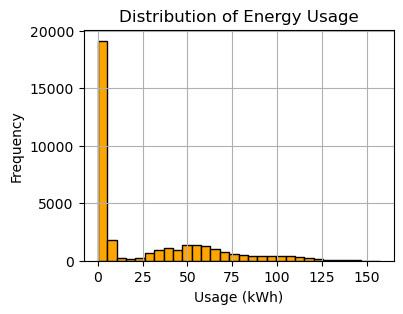

In [71]:
# Histogram to check the distribution of energy usage
plt.figure(figsize=(4, 3))
plt.hist(Steel_industry_data_df['Usage_kWh'], bins=30, color='orange', edgecolor='black')
plt.xlabel('Usage (kWh)')
plt.ylabel('Frequency')
plt.title('Distribution of Energy Usage')
plt.grid(True)
plt.show()

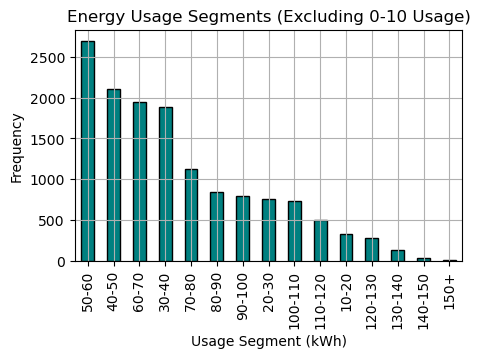

In [332]:
# Segmenting the energy consumption into ranges, excluding the (0-10) values.

# Define bins for segmenting the data into ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', 
          '100-110', '110-120', '120-130', '130-140', '140-150', '150+']

# Create a new column with the segment labels
Steel_industry_data_df['Usage_Segment'] = pd.cut(Steel_industry_data_df['Usage_kWh'], bins=bins, labels=labels)

# Count the number of records in each segment
segment_counts = Steel_industry_data_df['Usage_Segment'].value_counts()

# Filter out the '0-10' category from segment_counts
segment_counts = segment_counts[segment_counts.index != '0-10']

# Plot the segment counts
plt.figure(figsize=(5, 3))
segment_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.xlabel('Usage Segment (kWh)')
plt.ylabel('Frequency')
plt.title('Energy Usage Segments (Excluding 0-10 Usage)')
plt.grid(True)
plt.show()


<Axes: xlabel='Load_Type'>

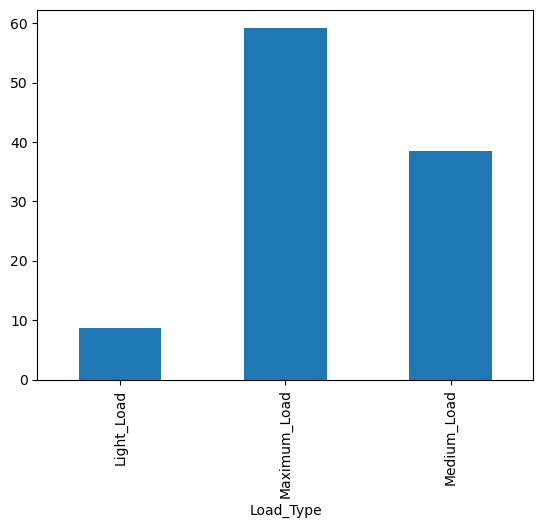

In [131]:
# General consumption analysis based on Load_Type
Steel_industry_data_df.groupby('Load_Type')['Usage_kWh'].mean().plot(kind='bar')

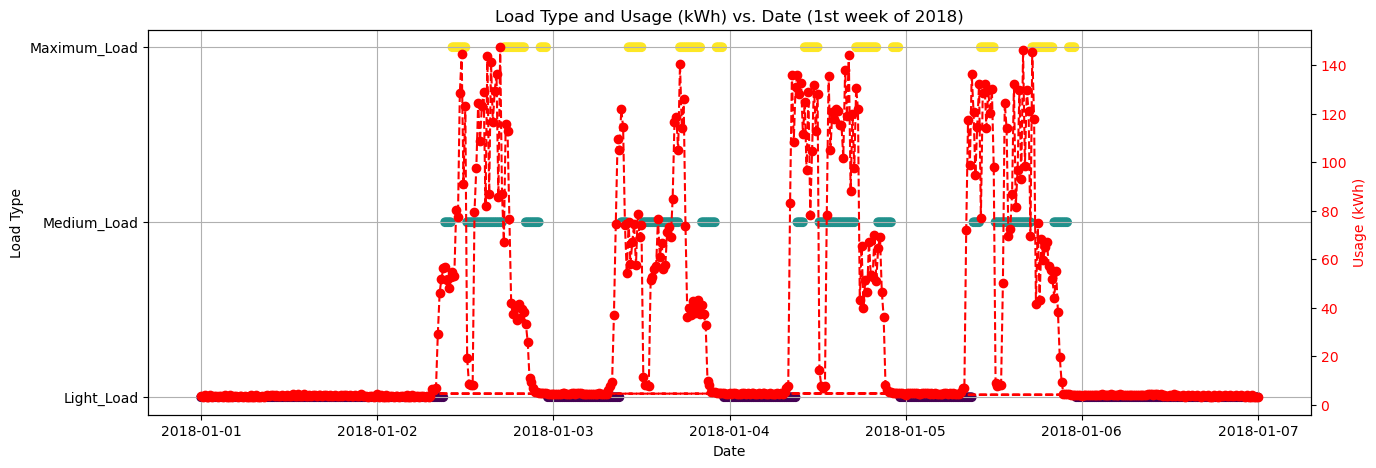

In [202]:
# Filter data for the period between January 2018 and February 2018
start_date = '2018-01-01'
end_date = '2018-01-07'

mask_start = Steel_industry_data_df['date'] >= start_date
mask_end = Steel_industry_data_df['date'] <= end_date
filtered_data = Steel_industry_data_df[mask_start & mask_end]

# Map Load_Type to integers
load_type_mapping = {'Light_Load': 1, 'Medium_Load': 2, 'Maximum_Load': 3}
filtered_data.loc[:, 'Load_Type_Numeric'] = filtered_data['Load_Type'].map(load_type_mapping)

# Plot Load_Type and Usage_kWh vs. date for the specified period
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot Load_Type on the left y-axis
ax1.scatter(filtered_data['date'], 
            filtered_data['Load_Type_Numeric'], 
            c=filtered_data['Load_Type_Numeric'], 
            cmap='viridis', label='Load Type')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load Type')
ax1.set_yticks([1, 2, 3])
ax1.set_yticklabels(['Light_Load', 'Medium_Load', 'Maximum_Load'])
ax1.tick_params(axis='y')

# Create a second y-axis for Usage_kWh
ax2 = ax1.twinx()
ax2.plot(filtered_data['date'], 
         filtered_data['Usage_kWh'], 
         color='red', 
         label='Usage (kWh)', 
         linestyle='--', 
         marker='o')
ax2.set_ylabel('Usage (kWh)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Load Type and Usage (kWh) vs. Date (1st week of 2018)')
ax1.grid(True)

# Show plot
plt.show()


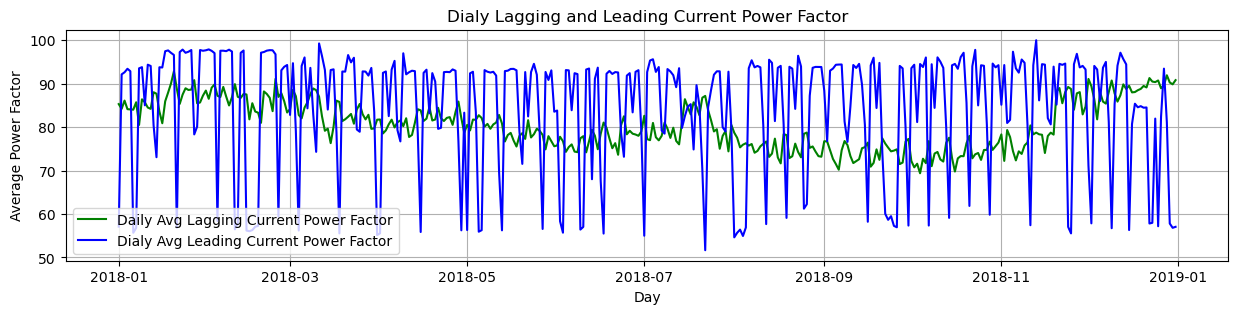

In [364]:
# First, the lagging and leading data are daily averaged.

# Resample the (Lagging_Current_Power_Factor) data by day and calculate the mean usage per day
daily_lagging = Steel_industry_data_df.resample('D', on='date')['Lagging_Current_Power_Factor'].mean()

# Resample the (Leading_Current_Power_Factor) data by day and calculate the mean usage per day
daily_leading = Steel_industry_data_df.resample('D', on='date')['Leading_Current_Power_Factor'].mean()

# Plot the resampled data for both Lagging and Leading Current Power Factor
plt.figure(figsize=(15, 3))

# Plot Lagging_Current_Power_Factor
plt.plot(daily_lagging.index, daily_lagging.values, label='Daily Avg Lagging Current Power Factor', color='green')

# Plot Leading_Current_Power_Factor
plt.plot(daily_leading.index, daily_leading.values, label='Dialy Avg Leading Current Power Factor', color='blue')

# Add labels, title, and legend
plt.xlabel('Day')
plt.ylabel('Average Power Factor')
plt.title('Dialy Lagging and Leading Current Power Factor')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.show()


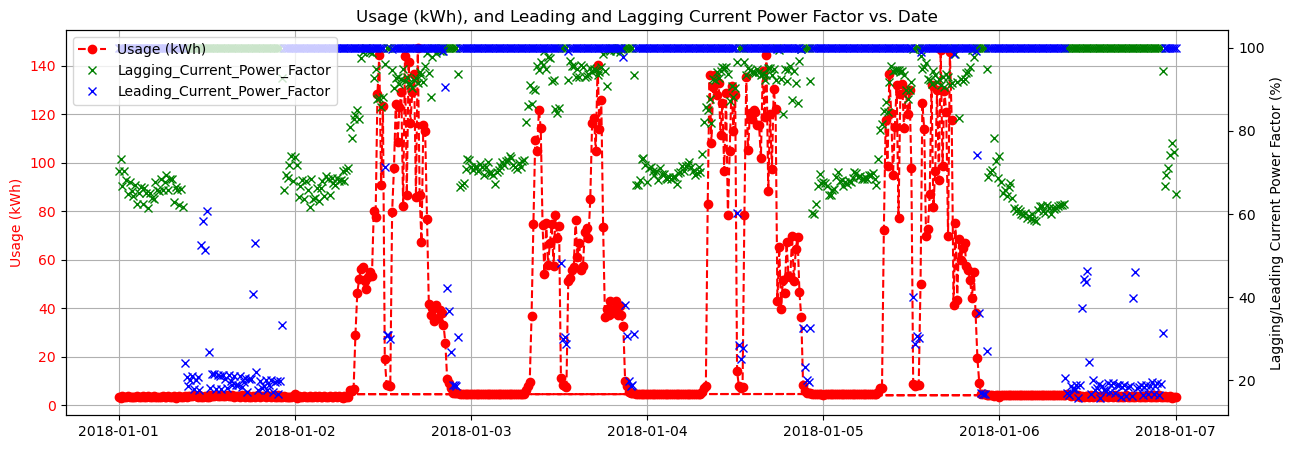

In [450]:
# Second, the Lagging and Leading data are investigated along the energy usage (Usage_kWh)

# Filter data for the period between January 2018 and February 2018
start_date = '2018-01-01'
end_date = '2018-01-07'

mask_start = Steel_industry_data_df['date'] >= start_date
mask_end = Steel_industry_data_df['date'] <= end_date
filtered_data = Steel_industry_data_df[mask_start & mask_end].copy()

# Plot Usage_kWh vs. date for the specified period
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot Usage_kWh on the left y-axis
ax1.plot(filtered_data['date'], 
         filtered_data['Usage_kWh'], 
         color='red', 
         label='Usage (kWh)', 
         linestyle='--', 
         marker='o')
ax1.set_ylabel('Usage (kWh)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for Leading and Lagging data
ax2 = ax1.twinx()

# Plot Leading and Lagging data on the second y-axis
ax2.plot(filtered_data['date'], 
         filtered_data['Lagging_Current_Power_Factor'], 
         color='green', 
         label='Lagging_Current_Power_Factor', 
         linestyle='', 
         marker='x')

ax2.plot(filtered_data['date'], 
         filtered_data['Leading_Current_Power_Factor'], 
         color='blue', 
         label='Leading_Current_Power_Factor', 
         linestyle='', 
         marker='x')

ax2.set_ylabel('Lagging/Leading Current Power Factor (%)', color='black')

# Combine the legends of both plots
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Add title and grid
plt.title('Usage (kWh), and Leading and Lagging Current Power Factor vs. Date')
ax1.grid(True)

# Show plot
plt.show()


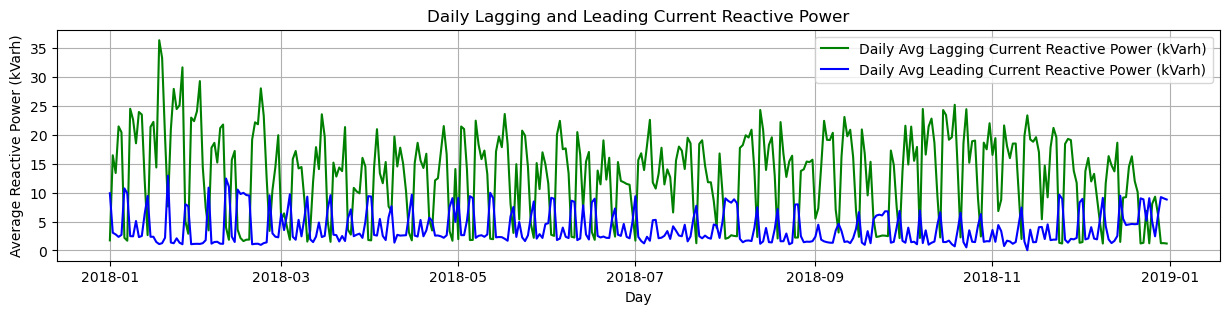

In [366]:
# First, the lagging and leading data are daily averaged.

# Resample the (Lagging_Current_Reactive.Power_kVarh) data by day and calculate the mean usage per day
daily_lagging = Steel_industry_data_df.resample('D', on='date')['Lagging_Current_Reactive.Power_kVarh'].mean()

# Resample the (Leading_Current_Reactive_Power_kVarh) data by day and calculate the mean usage per day
daily_leading = Steel_industry_data_df.resample('D', on='date')['Leading_Current_Reactive_Power_kVarh'].mean()

# Plot the resampled data for both Lagging and Leading Current Reactive Power
plt.figure(figsize=(15, 3))

# Plot Lagging_Current_Reactive.Power_kVarh
plt.plot(daily_lagging.index, daily_lagging.values, label='Daily Avg Lagging Current Reactive Power (kVarh)', color='green')

# Plot Leading_Current_Reactive_Power_kVarh
plt.plot(daily_leading.index, daily_leading.values, label='Daily Avg Leading Current Reactive Power (kVarh)', color='blue')

# Add labels, title, and legend
plt.xlabel('Day')
plt.ylabel('Average Reactive Power (kVarh)')
plt.title('Daily Lagging and Leading Current Reactive Power')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.show()


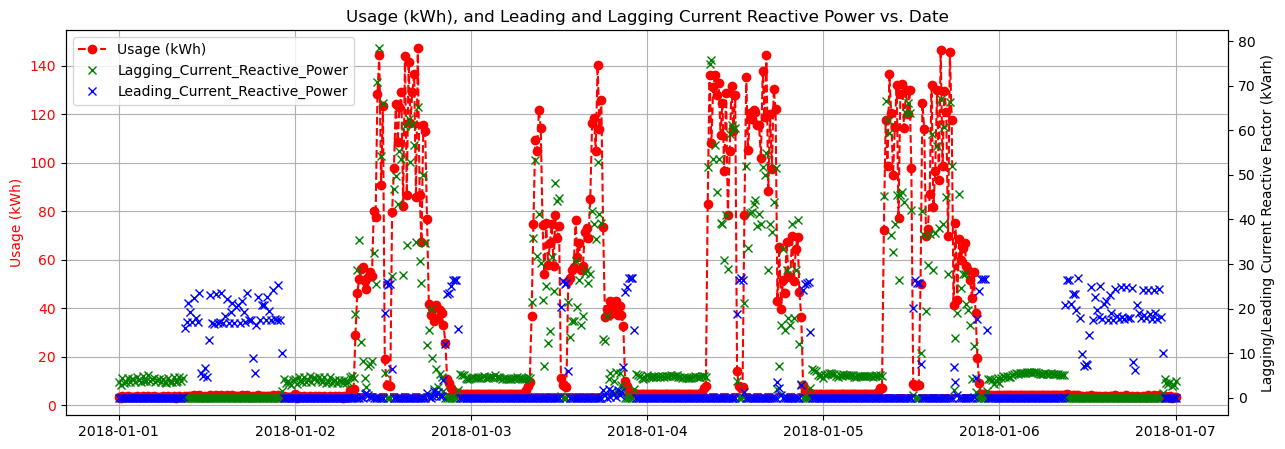

In [456]:
# Second, the Lagging and Leading data are investigated along the energy usage (Usage_kWh)

# Filter data for the period between January 2018 and February 2018
start_date = '2018-01-01'
end_date = '2018-01-07'

mask_start = Steel_industry_data_df['date'] >= start_date
mask_end = Steel_industry_data_df['date'] <= end_date
filtered_data = Steel_industry_data_df[mask_start & mask_end].copy()

# Plot Usage_kWh vs. date for the specified period
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot Usage_kWh on the left y-axis
ax1.plot(filtered_data['date'], 
         filtered_data['Usage_kWh'], 
         color='red', 
         label='Usage (kWh)', 
         linestyle='--', 
         marker='o')
ax1.set_ylabel('Usage (kWh)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for Leading and Lagging data
ax2 = ax1.twinx()

# Plot Leading and Lagging data on the second y-axis
ax2.plot(filtered_data['date'], 
         filtered_data['Lagging_Current_Reactive.Power_kVarh'], 
         color='green', 
         label='Lagging_Current_Reactive_Power', 
         linestyle='', 
         marker='x')

ax2.plot(filtered_data['date'], 
         filtered_data['Leading_Current_Reactive_Power_kVarh'], 
         color='blue', 
         label='Leading_Current_Reactive_Power', 
         linestyle='', 
         marker='x')

ax2.set_ylabel('Lagging/Leading Current Reactive Factor (kVarh)', color='black')

# Combine the legends of both plots
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Add title and grid
plt.title('Usage (kWh), and Leading and Lagging Current Reactive Power vs. Date')
ax1.grid(True)

# Show plot
plt.show()

SECTION II

Energy Consumption Optimisation with SQL
-----------------------------------------

In [476]:
# Load sql magic commads
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [478]:
# Create a SQLite database
%sql sqlite:///steel_industry_DB.db

In [480]:
# Creat connection to SQLite database
conn = sqlite3.connect('steel_industry_DB.db')

# Save DataFrame to SQL table
Steel_industry_data_df.to_sql('Steel_industry_data', conn, if_exists='replace', index=False)

# Retrieve general metadata information using SQL
%sql PRAGMA table_info('Steel_industry_data')

 * sqlite:///steel_industry_DB.db
Done.


cid,name,type,notnull,dflt_value,pk
0,date,TIMESTAMP,0,None,0
1,Usage_kWh,REAL,0,None,0
2,Lagging_Current_Reactive.Power_kVarh,REAL,0,None,0
3,Leading_Current_Reactive_Power_kVarh,REAL,0,None,0
4,CO2(tCO2),REAL,0,None,0
5,Lagging_Current_Power_Factor,REAL,0,None,0
6,Leading_Current_Power_Factor,REAL,0,None,0
7,NSM,INTEGER,0,None,0
8,WeekStatus,TEXT,0,None,0
9,Day_of_week,TEXT,0,None,0


In [496]:
%%sql
DROP TABLE IF EXISTS Equipment_info;
DROP TABLE IF EXISTS Environmental_factor;
DROP TABLE IF EXISTS Cost;

CREATE TABLE Equipment_info (
    equipment_id SERIAL PRIMARY KEY,       -- Unique identifier for each piece of equipment
    equipment_name VARCHAR(100) NOT NULL,  -- Name of the equipment
    model_name VARCHAR(100) NOT NULL,      -- Name of the equipment model
    model_number VARCHAR(50) NOT NULL,     -- Model number
    number_of_units INT NOT NULL,          -- Number of units of the equipment
    purpose TEXT,                          -- Purpose of the equipment
    maintenance TEXT,                      -- Description of maintenance schedule or tasks
    energy_usage DECIMAL(10, 2),           -- Energy consumption in kWh
    load_kw DECIMAL(10, 2),                -- Load capacity in kW
    operation_hours_per_week INT           -- Number of hours the equipment operates per week
);

CREATE TABLE Environmental_factor (
    date DATE PRIMARY KEY,                -- Unique date for each row
    temperature_outside DECIMAL(5, 2),    -- Temperature outside in C
    temperature_inside DECIMAL(5, 2),     -- Temperature inside in C
    humidity_outside DECIMAL(5, 2),       -- Humidity outside in percentage
    humidity_inside DECIMAL(5, 2)         -- Humidity inside in percentage
);

CREATE TABLE Cost (
    general_id SERIAL PRIMARY KEY,        -- Unique identifier for each record
    equipment_id INT NOT NULL,            -- Foreign key to link the equipment
    equipment_price DECIMAL(10, 2),       -- Price of the equipment in currency units
    maintenance_price DECIMAL(10, 2),     -- Maintenance cost in currency units
    monthly_energy_cost DECIMAL(10, 2),   -- Monthly energy cost in currency units
    FOREIGN KEY (equipment_id) REFERENCES Equipment_info(equipment_id)  -- Links cost to the equipment table
);


 * sqlite:///steel_industry_DB.db
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [ ]:
# Investigate whether the loads_type has an essential impact on energy consumption.

In [206]:
%%sql
-- Retrieve the time of day for different load types (Medium, Maximum, and Light) on a single weekday.
-- The `CASE` statements are used to select the time associated with each Load_Type.
-- The `TIME(date)` extracts the time part of the timestamp from the `date` column.
-- This query filters the results for January 2, 2018 as a sample.

SELECT 
    TIME(date) AS Time_of_Day,
    CASE WHEN Load_Type = 'Medium_Load' THEN TIME(date) END AS Medium_Load_Time,
    CASE WHEN Load_Type = 'Maximum_Load' THEN TIME(date) END AS Maximum_Load_Time,
    CASE WHEN Load_Type = 'Light_Load' THEN TIME(date) END AS Light_Load_Time
FROM Steel_industry_data 
WHERE DATE(date) = '2018-01-02'
AND Load_Type IN ('Medium_Load', 'Maximum_Load', 'Light_Load')


 * sqlite:///steel_industry_DB.db
Done.


Time_of_Day,Medium_Load_Time,Maximum_Load_Time,Light_Load_Time
00:15:00,None,None,00:15:00
00:30:00,None,None,00:30:00
00:45:00,None,None,00:45:00
01:00:00,None,None,01:00:00
01:15:00,None,None,01:15:00
01:30:00,None,None,01:30:00
01:45:00,None,None,01:45:00
02:00:00,None,None,02:00:00
02:15:00,None,None,02:15:00
02:30:00,None,None,02:30:00


In [ ]:
# Return top 10 days with the highest total energy consumption within the period 2018-09 and 2019-01, 
# along with the average power factors and average energy usage for those days

In [538]:
%%sql

SELECT 
    DATE(date) AS Day, 
    SUM(Usage_kWh) AS Total_Energy_Consumption,
    AVG(Lagging_Current_Power_Factor) AS Avg_Lagging_Power_Factor,
    AVG(Leading_Current_Power_Factor) AS Avg_Leading_Power_Factor,
    AVG(Usage_kWh) AS Avg_usage
FROM Steel_industry_data
WHERE date BETWEEN '2018-09-01' AND '2019-01-31'
GROUP BY Day
ORDER BY Total_Energy_Consumption DESC
LIMIT 10

 * sqlite:///steel_industry_DB.db
Done.


Day,Total_Energy_Consumption,Avg_Lagging_Power_Factor,Avg_Leading_Power_Factor,Avg_usage
2018-11-13,4726.84,78.72604166666666,99.99916666666667,49.23791666666667
2018-10-15,4431.24,72.916875,94.22083333333335,46.15875
2018-11-21,4292.86,88.9928125,94.56635416666667,44.71729166666666
2018-11-22,4281.03,85.489375,94.32510416666666,44.5940625
2018-11-27,4266.93,87.76322916666668,96.86645833333334,44.447187500000005
2018-10-10,4200.28,74.27374999999999,96.05333333333334,43.752916666666664
2018-09-07,4184.71,74.66989583333334,94.41031249999999,43.59072916666667
2018-12-14,4129.66,88.78270833333333,94.44416666666666,43.017291666666665
2018-09-04,4120.7,72.67302083333333,93.47135416666667,42.92395833333333
2018-10-08,4057.45,70.99625,94.47083333333335,42.26510416666667


In [ ]:
# Which month had the HIGHST energy consumption? and which had the LOWEST?

In [562]:
%%sql

SELECT * FROM (
    SELECT 
        strftime('%Y-%m', date) AS Month,    -- Extract year and month
        SUM(Usage_kWh) AS Total_Energy_Consumption
    FROM Steel_industry_data
    GROUP BY Month
    ORDER BY Total_Energy_Consumption DESC
    LIMIT 1
)
UNION ALL
SELECT * FROM (
    SELECT 
        strftime('%Y-%m', date) AS Month,    -- Extract year and month
        SUM(Usage_kWh) AS Total_Energy_Consumption
    FROM Steel_industry_data
    GROUP BY Month
    ORDER BY Total_Energy_Consumption ASC
    LIMIT 1
)

 * sqlite:///steel_industry_DB.db
Done.


Month,Total_Energy_Consumption
2018-01,126238.29
2018-09,57883.07


In [504]:
%%sql

-- Find Equipment with the Highest Monthly Energy Costs:

SELECT e.model_name, e.model_number, c.monthly_energy_cost
FROM Equipment_info e
JOIN Cost c ON e.equipment_id = c.equipment_id
ORDER BY c.monthly_energy_cost DESC;


 * sqlite:///steel_industry_DB.db
Done.


model_name,model_number,monthly_energy_cost


In [512]:
%%sql

-- AnalySe Energy Usage Based on Environmental Factors:

SELECT ef.date, ef.temperature_outside, ef.humidity_outside, sid.Usage_kWh
FROM Environmental_factor ef
JOIN Steel_industry_data sid ON ef.date = sid.date
WHERE sid.Load_Type == 'Maximum_Load'  -- Filtering by Maximum load
ORDER BY ef.date;


 * sqlite:///steel_industry_DB.db
Done.


date,temperature_outside,humidity_outside,Usage_kWh


In [514]:
%%sql

-- Calculate the Total Maintenance and Energy Costs:

SELECT e.equipment_name, SUM(c.maintenance_price + c.monthly_energy_cost) AS total_cost
FROM Equipment_info e
JOIN Cost c ON e.equipment_id = c.equipment_id
GROUP BY e.model_name
ORDER BY total_cost DESC;


 * sqlite:///steel_industry_DB.db
Done.


equipment_name,total_cost
